Consider the finite problem defined as:

\begin{equation}
-\frac{\hbar^2}{2m} \frac{d^2  \psi}{dx^2}  + V(x) \psi =  E \psi
\end{equation}

where

*   $\hbar $ is the reduced Planck's constant
*   $m$ is the mass of particle
*  $\psi $ is the wavefunction (representing the eigenfunction/ eigenstate)
* $V(x) $ is the potential energy of the particle at any point $x$,
defined as
\begin{equation}
    V(x) =
    \begin{cases}
        0 & -l < x <  l, \\
        V_0 &  otherwise.
    \end{cases}
\end{equation}
* $E$ is the energy of the particle (representing the eigenvalue of the equation)

Taking $l = 6$, $h = 1, m = 1 $ and $V_0 = 20$

In [ ]:
#Importing the required libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import grad
from torch import Tensor
import torch.nn as nn
import torch.optim as optim     #optimizer
import time
import copy


#Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda':
  print(torch.cuda.get_device_name(0))


cuda


In [ ]:
#The sine activation function
class sine(torch.nn.Module):
  @staticmethod
  def forward(input):
    return torch.sin(input)

#Automatic differentiation in pytorch
def dfx(f,x):
  gouts = torch.ones(x.shape, dtype=torch.float, device = device)
  return grad([f],[x],grad_outputs=gouts, create_graph=True)[0]

In [ ]:
#Defining the Parametric Solution
#This enforces the solution on the boundaries
def parametricSolutions(t,nn,t0,tf, bound):
  N1 = nn(t)
  dt1 = t - t0
  dt2 = t - tf
  f = (1-torch.exp(-dt1))*(1-torch.exp(dt2))
  psi_hat = bound + f*N1
  return psi_hat

In [ ]:
def hamEqs_Loss(t,psi, pot,iter,V_max,breakpoints,E_count):
  if iter < 5000:
    psi_init = torch.exp(-t**2)
    f = psi - psi_init
    L = (f.pow(2)).mean()
    return L
  else:
    psi_x = dfx(psi,t)
    psi_xx = dfx(psi_x,t)
    E  = ((torch.dot(psi[:,0], -0.5*psi_xx[:,0] + pot[:,0] * psi[:,0]))/(torch.dot(psi[:,0],psi[:,0]))) ####
    discrete_loss = 10*torch.exp(E-V_max)*torch.clamp(torch.sign(E - V_max), min=0)
    f = (-0.5*(psi_xx) + (pot - E)*psi)#/torch.sqrt(torch.dot(psi[:,0],psi[:,0]))
    L = (f.pow(2)).mean()
    return L,E, discrete_loss

In [ ]:
#defining the potential
def V(x):
  x = x.data.numpy()
  x0 = 5
  vnp = (np.heaviside(-x-x0,0) + np.heaviside(x-x0,0))*10
  return torch.from_numpy(vnp)

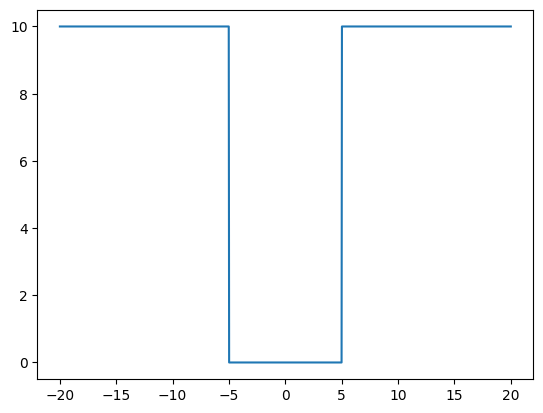

In [ ]:
x = torch.linspace(-20,20,1200).view(-1,1)
pot = V(x)
plt.plot(x,pot)
plt.show()
#pot.shape

In [ ]:
#Defining the NN architecture without symmetry
class qNN(torch.nn.Module):
  def __init__(self,layers):
    super(qNN,self).__init__()
    self.activation = sine()

    #Defining the Layers
    self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers) - 1)])
    #self.batch_norms = nn.ModuleList([nn.BatchNorm1d(layers[i+1]) for i in range(len(layers) - 2)])

    #Initializing the weights
    #self.apply(weights_init)
    for i in range(len(layers)-1):
      nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
      nn.init.zeros_(self.linears[i].bias.data)


  #Defining the forward pass
  def forward(self,x):
    if torch.is_tensor(x) != True:
      x = torch.from_numpy(x)
    a = x.float()
    #In1 = self.ein(torch.ones_like(a))
    for i in range(len(self.linears)-1):
      z = self.linears[i](a)
      #z = self.batch_norms[i](z)
      a = self.activation(z)

    a = self.linears[-1](a)
    return a

In [ ]:
def points_inside_well(x):
  x = x.detach().cpu().numpy()
  PIW = np.heaviside(x-1.7,0) + np.heaviside(-x-1.7,0)
  return abs(PIW -1)

In [ ]:
#Defining the hyperparameters
t0 =-20; tf = 20; xbc = 0
col_pts = 1200; layers = [1,100,100,1]; lr = 1e-2; epochs = 60000
breakpoints =[10000,20000,30000,40000,50000]

In [ ]:
def save_checkpoint(state, filename='last_checkpoint_fpwp.pth.tar'):
  print('=========================')
  print('Saving checkpoint')
  print('=========================')
  torch.save(state, filename)

In [ ]:
model = qNN(layers)
model.to(device)
print(model)
params = list(model.parameters())
#print(params)
betas = [0.999, 0.9999]
optimizer = optim.Adam(model.parameters(), lr=lr, betas=betas)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor = 0.5, patience = 10, verbose = True)

qNN(
  (activation): sine()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=1, bias=True)
  )
)


In [ ]:
#To learn multiple eigenvlues and eigenvectors, we will need both the orthogonality and orthonormality ppty
def nn_train(qNN,t0,tf,xbc,col_pts,checkpoints, epochs):
  En_history = [] #To store the eigenvalues as it is optimized
  SE_loss_hist = [] #To store the pde loss
  internal_loss_hist = [] #To compute loss for rolling mean
  Loss_hist = []#To store the total loss after every epoch
  grid = torch.linspace(t0,tf,col_pts).view(-1,1) #The collocation points
  t_rand = grid.to((device))
  t_rand.requires_grad =True
  t_plot = t_rand.cpu().detach().numpy() #For training plots
  orth_counter = 0
  En_counter = []
  #Dictionary for storing the learned eigenfunction
  dic = {}
  load_model = False #To load the model from the last checkpoint

  stime = time.time()
  if load_model:
    print('=========================')
    print('Loading checkpoint')
    print('=========================')
    checkpoint = torch.load('last_checkpoint_fpwp.pth.tar')
    qNN.load_state_dict(checkpoint['state_dict']); optimizer.load_state_dict(checkpoint['optimizer'])
    current = checkpoint['epoch']; orth_counter = checkpoint['orth_counter']; Loss_hist = checkpoint['Loss_hist']
    En_history = checkpoint['En_history'];dic = checkpoint['dic']; En_counter = checkpoint['En_counter']
    print('=========================')
    print('Loaded checkpoint')
    print('=========================')
  else:
    current = 0
  #for iter in range(current+1,epochs + 1): #Comment this line if load_model = False
  for iter in range(epochs + 1): #Comment this line if True
    NN = qNN(t_rand) #The forward pass
    loss = 0.0
    #Getting the parametric solution
    psi = parametricSolutions(t_rand,qNN,t0,tf,xbc).to(device)
    psi = psi#/torch.sqrt(torch.dot(psi[:,0],psi[:,0])) #Normalizing psi
    Vx = V(t_rand.cpu()).to(device)



    #Derivatives needed when computing en_loss
    psi_x = dfx(psi,t_rand)
    psi_xx = dfx(psi_x,t_rand)

    if iter < 5000:
      total_loss = hamEqs_Loss(t_rand,psi, Vx,iter,V_max,checkpoints,En_counter)
      if iter % 300 == 0:
        print('--------------------------------------------')
        print('Epoch: ', iter)
        print('loss = ', total_loss.cpu().detach().numpy())
      if iter == 4900:
        checkpoint = {'psi': psi}
        save_checkpoint(checkpoint,'psi.pth.tar')
    else:
      pde_loss, En, discreete_loss = hamEqs_Loss(t_rand,psi, Vx,iter,V_max,checkpoints,En_counter)
      En_history.append(En.cpu().detach().numpy().item())
      #Getting the loss after the forward pass
      SE_loss_hist.append(pde_loss)
      internal_loss_hist.append(pde_loss.cpu().detach().numpy())
      #The loss for the patience condition
      criteria_loss = pde_loss


      #Adding the normalization as a regularization term
      NT = ( 1 - ((tf - t0) * torch.sqrt(torch.dot(psi[:,0],psi[:,0]))/ col_pts) ).pow(2)
      #Adding the nodal loss
      piw = torch.tensor(points_inside_well(t_rand)).to(device) #To remove the oscillations outside the well
      #node1_loss = torch.dot(psi[:,0],psi[:,0])*abs((torch.sum(abs(torch.diff(torch.sign(torch.diff(psi[:,0]*piw[:,0])))/2)) - 2)) #loss of the peaks
      node1_loss = 10*abs((torch.sum(abs(torch.diff(torch.sign(torch.diff(psi[:,0]*piw[:,0])))/2)) - 2))
      total_loss = NT + node1_loss + criteria_loss + discreete_loss





    #if iter == current + 1:
    #  qNN.apply(weights_init)

      for index, breakpoint in enumerate(breakpoints):
        if iter == breakpoint and orth_counter == index:
          dic[index] = copy.deepcopy(qNN)
          En_counter.append(En_history[-1])
          orth_counter += 1
          psi_i = parametricSolutions(t_rand, dic[index],t0,tf,xbc)
          psi = psi_i * (t_rand) # max is at 0
          print('==========================================')
          print(f"Learned {index+1} Eigenvalues")
          print('==========================================')
          #saving a checkpoint for future iterations
          checkpoint = {
              'state_dict': qNN.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': iter, 'Loss_hist': Loss_hist,
              'orth_counter': orth_counter, 'En_history': En_history, 'dic': dic, 'En_counter': En_counter
          }
          save_checkpoint(checkpoint)



      #Calculating condition for the lossses
      #Getting the condition for the en_loss
      if orth_counter > 0:
        diff = ((torch.dot(psi[:,0], -0.5*psi_xx[:,0] + Vx[:,0] * psi[:,0]))/(torch.dot(psi[:,0],psi[:,0]))) - En_counter[-1]
        #en_loss = 0 if diff > 0 else 5*torch.exp(-diff)
        en_loss = 5*torch.clamp(torch.sign(-diff), min=0)*torch.exp(-diff)
        ortho_loss = 0

        #Normalizing the orthogonal loss
        for i in range(orth_counter):
          psi_i = parametricSolutions(t_rand,dic[i],t0,tf,xbc)[:,0]
          ortho = torch.sqrt(torch.dot(psi_i, psi[:,0]).pow(2))/ (torch.sqrt(torch.dot(psi_i, psi_i) * torch.sqrt(torch.dot(psi[:,0], psi[:,0]))))
          ortho_loss += ortho
        noden_loss = 10*abs((torch.sum(abs(torch.diff(torch.sign(torch.diff(psi[:,0]*piw[:,0]))))/2) - 2 - orth_counter))
        total_loss +=  ortho_loss/7 + en_loss + noden_loss - node1_loss


      if iter % 300 == 0:
        #Plot the network after every 300 iterations
        #fig,ax1 = plt.subplots(figsize=(4,3))
        #psi_plot = psi.cpu().detach().numpy()
        #ax1.plot(t_plot, psi_plot, label= f'Total_loss: {total_loss.cpu().detach().numpy():.5f} ')
        #ax1.set_title(f'Epoch: {iter}, En: {En_history[-1]:.7f}, oc: {orth_counter}')
        #ax1.legend()
        #plt.show()
        print('--------------------------------------------')
        print('Epoch: ', iter)
        print('En: ', En_history[-1])
        print('oc: ', orth_counter)
        print('--------------------------------------------')
        print('Total_loss: ',total_loss.cpu().detach().numpy())
        if orth_counter > 0:
          print('ortho_loss: ', ortho_loss.cpu().detach().numpy())
          print('en_loss: ',en_loss.cpu().detach().numpy())
        print('pde_loss: ', criteria_loss.cpu().detach().numpy())
        print('NT: ', NT.cpu().detach().numpy())
        print('nodal_loss1: ',node1_loss.cpu().detach().numpy()) if orth_counter == 0 else print('nodal_lossn: ',noden_loss.cpu().detach().numpy())
        print('Discrete loss: ', discreete_loss.cpu().detach().numpy())

        for name, param in qNN.named_parameters():
          if param.grad is not None:
            print(f'Parameter: {name}, Gradient Norm: {torch.norm(param.grad)}')

    #Backward propagation
    optimizer.zero_grad()
    total_loss.backward()
    #Introducing Gradient clipping
    #max_norm =5.0
    #torch.nn.utils.clip_grad_norm_(qNN.parameters(), max_norm)
    optimizer.step()
    loss += total_loss.cpu().detach().numpy()


    #Storing the loss after each iteration
    Loss_hist.append(loss)
    #Scheduling the learning rate
    #scheduler.step(total_loss)


  #Storing the final eigenfunction and eigenvalue
  dic[orth_counter] = copy.deepcopy(qNN)
  En_counter.append(En_history[-1])


  ftime = time.time()
  ttime = (ftime - stime)/60
  print(f'Total training time is {ttime} minutes')
  return Loss_hist, En_history, En_counter, dic

In [ ]:
Loss, eig_vals, eig_count, qPINN = nn_train(model,t0,tf,xbc,col_pts,breakpoints,epochs)

--------------------------------------------
Epoch:  0
loss =  0.09827015
--------------------------------------------
Epoch:  300
loss =  0.035705067
--------------------------------------------
Epoch:  600
loss =  0.02669744
--------------------------------------------
Epoch:  900
loss =  0.019117974
--------------------------------------------
Epoch:  1200
loss =  0.01068532
--------------------------------------------
Epoch:  1500
loss =  0.0066849375
--------------------------------------------
Epoch:  1800
loss =  0.006070424
--------------------------------------------
Epoch:  2100
loss =  0.0030318042
--------------------------------------------
Epoch:  2400
loss =  0.0018992876
--------------------------------------------
Epoch:  2700
loss =  0.0017326074
--------------------------------------------
Epoch:  3000
loss =  0.0010480589
--------------------------------------------
Epoch:  3300
loss =  0.0007497978
--------------------------------------------
Epoch:  3600
loss =  0

KeyboardInterrupt: 

In [ ]:
checkpoint = torch.load('last_checkpoint_fpwp.pth.tar')
#qNN.load_state_dict(checkpoint['state_dict']); optimizer.load_state_dict(checkpoint['optimizer'])
current = checkpoint['epoch']; orth_counter = checkpoint['orth_counter']; Loss_hist = checkpoint['Loss_hist']
En_history = checkpoint['En_history'];dic = checkpoint['dic']; En_counter = checkpoint['En_counter']

In [ ]:
checkpoint = torch.load('psi.pth.tar')
psi = checkpoint['psi'].cpu().detach().numpy()
x = np.linspace(-20,20,1200).reshape(-1,1)
plt.plot(x,psi)

##Prediction

In [ ]:
En_counter

[0.35699889063835144,
 1.42373526096344,
 3.193462610244751,
 8.776448249816895,
 12.511524200439453]

In [ ]:
eig_count

In [ ]:
tTest = torch.linspace(-20,20,1400).view(-1,1)
tTest.requires_grad=True
t_net = tTest.detach().numpy()
#psi1 =parametricSolutions(tTest,dic[0].cpu(),t0,tf,xbc).data.numpy()
#psi2 =parametricSolutions(tTest,dic[1].cpu(),t0,tf,xbc).data.numpy()
#psi3 = parametricSolutions(tTest,dic[2].cpu(),t0,tf,xbc).data.numpy()
#psi4 = parametricSolutions(tTest,dic[3].cpu(),t0,tf,xbc).data.numpy()
#psi5 = parametricSolutions(tTest,dic[4].cpu(),t0,tf,xbc).data.numpy()

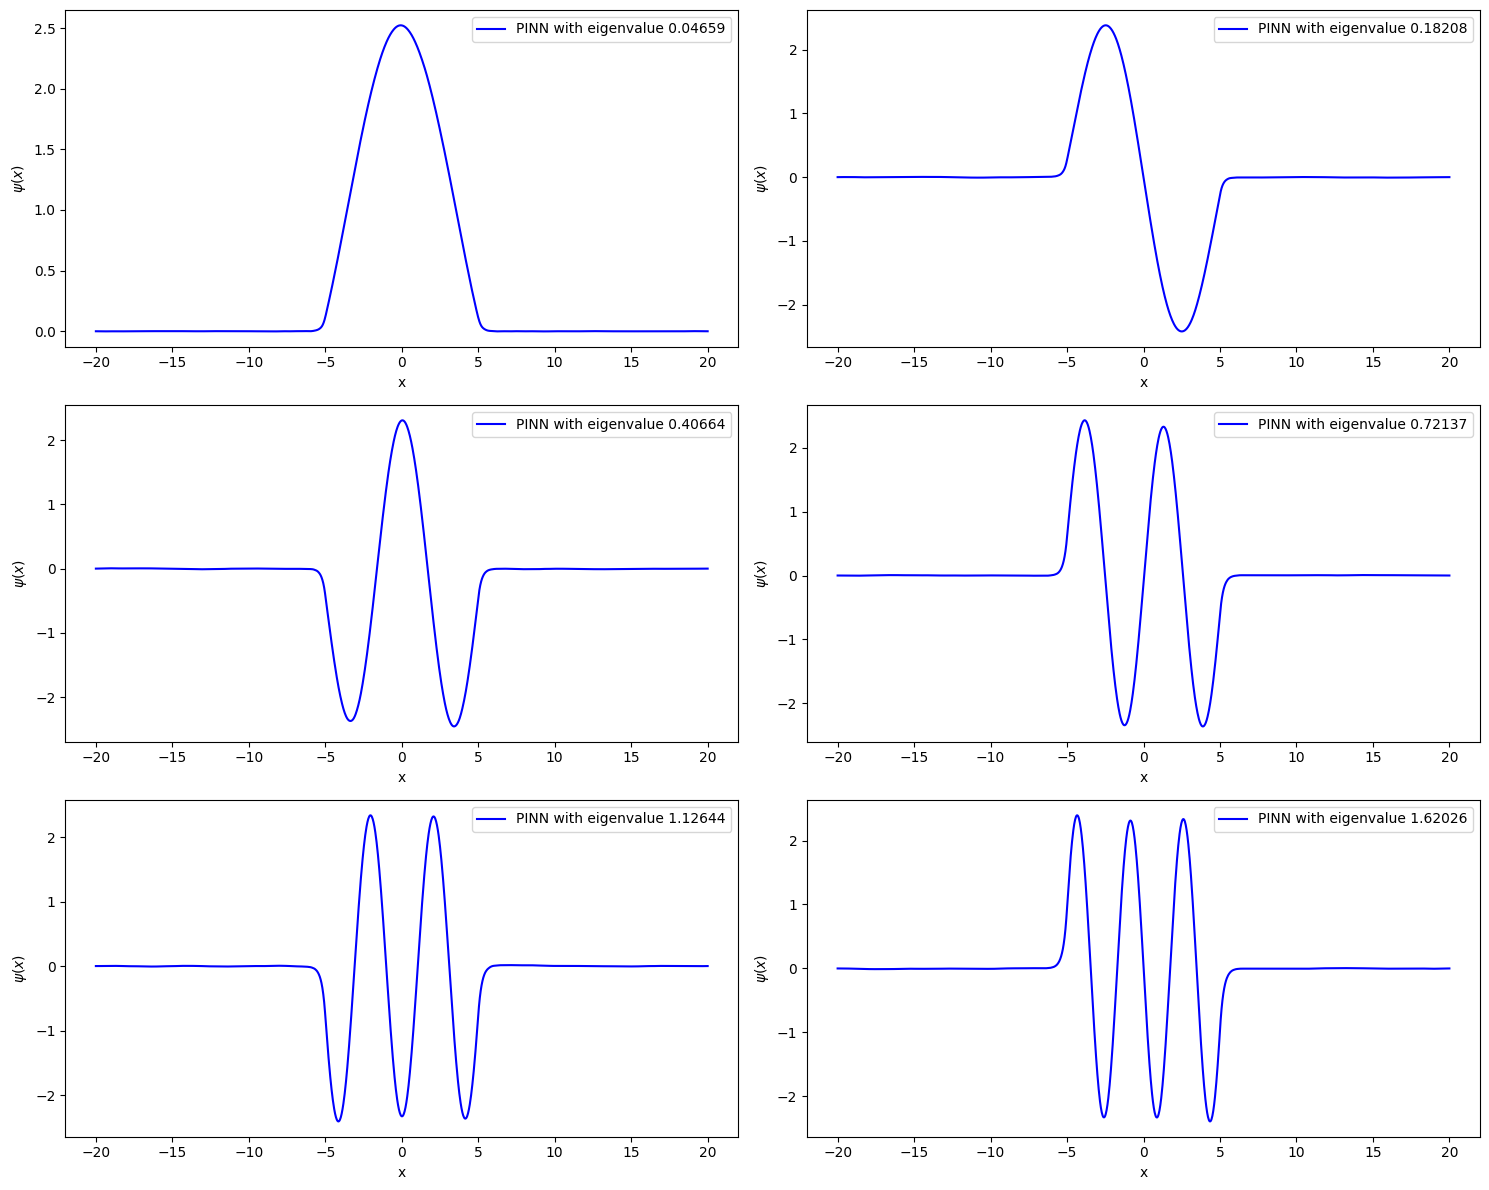

In [ ]:
# Define the number of rows and columns for the subplot grid
num_rows = 3
num_cols = 2

#The potential function
def Vx(x):
  x = x
  x0 = 1.7
  vnp = (np.heaviside(-x-x0,0) + np.heaviside(x-x0,0))*20
  return vnp
# Calculate the total number of subplots needed
total_subplots = num_rows * num_cols

# Create a figure and axes for the subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 12))

# Iterate over eigenvalues and corresponding solutions
for index, eig in enumerate(eig_count[:total_subplots]):
    psi = parametricSolutions(tTest, qPINN[index].cpu(), t0, tf, xbc).data.numpy()
    row_index = index // num_cols  # Calculate row index
    col_index = index % num_cols   # Calculate column index

    # Plot on the corresponding subplot
    ax = axes[row_index, col_index]
    ax.plot(t_net, psi , color='blue', label=f'PINN with eigenvalue {eig:.5f}')
    #ax.plot(t_net, Vx(t_net), color = 'green')
    #ax.plot(t_net, np.zeros(len(t_net)), '--k')
    ax.set_xlabel('x', color='black')
    ax.set_ylabel('$\psi(x)$', color='black')
    ax.tick_params(axis='y', color='black')
    ax.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


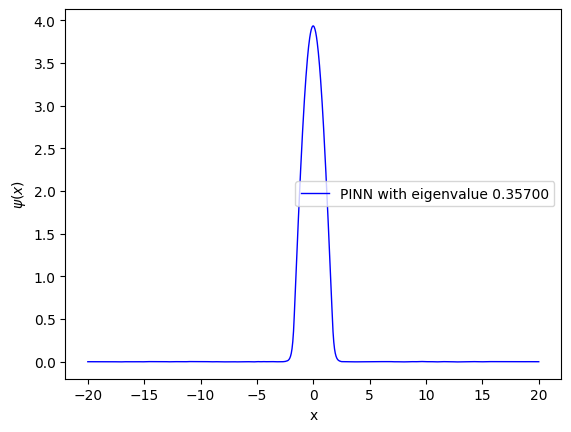

In [ ]:
fig, ax1 = plt.subplots()
ax1.plot(t_net, psi1, color='blue', linewidth=1, label=f'PINN with eigenvalue {En_counter[0]:.5f}')
#ax1.scatter(t_net, y2,marker = 'x',color='red',label='Exact_Solution')

#ax1.plot(t_net, np.zeros(len(t_net)),'--k', linewidth=2)
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('$\psi(x)$',color='black')
#ax1.set_xlim(0,3.2)
ax1.tick_params(axis='y', color='black')
ax1.legend()

#plt.grid('on')

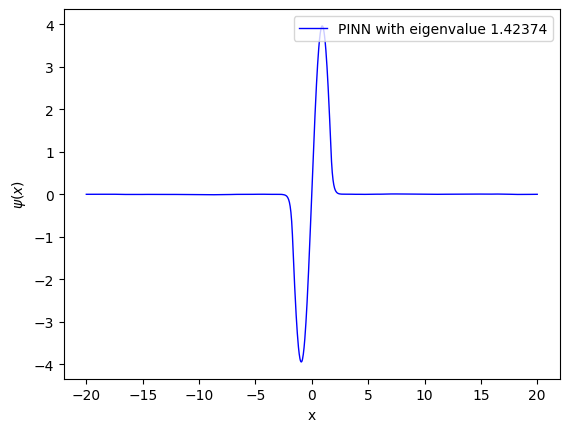

In [ ]:
fig, ax1 = plt.subplots()
ax1.plot(t_net, psi2, color='blue', linewidth=1, label=f'PINN with eigenvalue {En_counter[1]:.5f}')
#ax1.scatter(t_net, y2,marker = 'x',color='red',label='Exact_Solution')

#ax1.plot(t_net, np.zeros(len(t_net)),'--k', linewidth=2)
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('$\psi(x)$',color='black')
#ax1.set_xlim(0,3.2)
ax1.tick_params(axis='y', color='black')
ax1.legend()

#plt.grid('on')

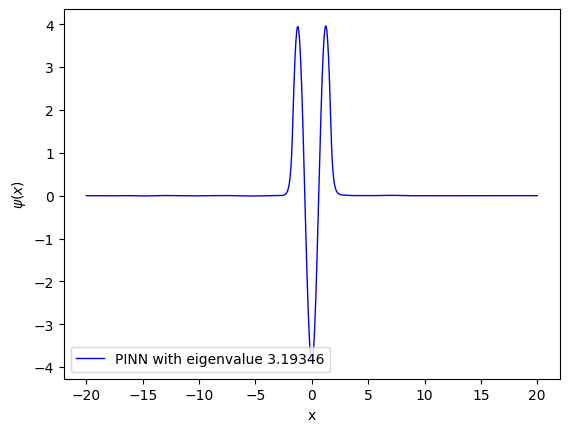

In [ ]:
fig, ax1 = plt.subplots()
ax1.plot(t_net, psi3, color='blue', linewidth=1, label=f'PINN with eigenvalue {En_counter[2]:.5f}')
#ax1.scatter(t_net, y2,marker = 'x',color='red',label='Exact_Solution')

#ax1.plot(t_net, np.zeros(len(t_net)),'--k', linewidth=2)
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('$\psi(x)$',color='black')
#ax1.set_xlim(0,3.2)
ax1.tick_params(axis='y', color='black')
ax1.legend()

#plt.grid('on')

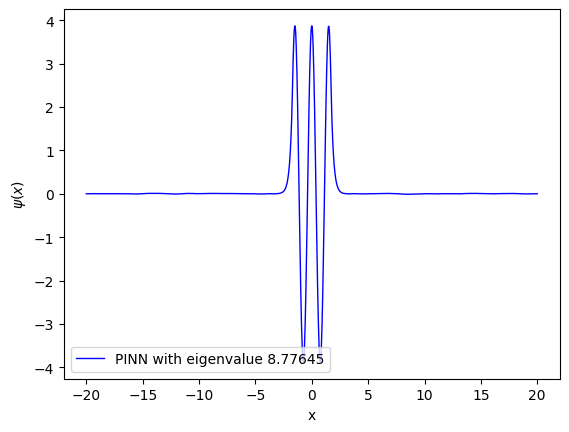

In [ ]:
fig, ax1 = plt.subplots()
ax1.plot(t_net, psi4, color='blue', linewidth=1, label=f'PINN with eigenvalue {En_counter[3]:.5f}')
#ax1.scatter(t_net, y2,marker = 'x',color='red',label='Exact_Solution')

#ax1.plot(t_net, np.zeros(len(t_net)),'--k', linewidth=2)
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('$\psi(x)$',color='black')
#ax1.set_xlim(0,3.2)
ax1.tick_params(axis='y', color='black')
ax1.legend()

#plt.grid('on')

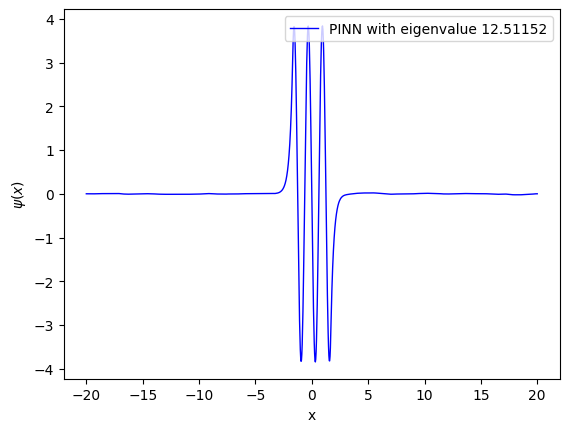

In [ ]:
fig, ax1 = plt.subplots()
ax1.plot(t_net, psi5, color='blue', linewidth=1, label=f'PINN with eigenvalue {En_counter[4]:.5f}')
#ax1.scatter(t_net, y2,marker = 'x',color='red',label='Exact_Solution')

#ax1.plot(t_net, np.zeros(len(t_net)),'--k', linewidth=2)
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('$\psi(x)$',color='black')
#ax1.set_xlim(0,3.2)
ax1.tick_params(axis='y', color='black')
ax1.legend()

#plt.grid('on')